# Simple Harmonic oscillator

## Import libraries

In [14]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn

## The physics

Lagrangian for simple harmonic oscillator

$$
L =   \frac{1}{2} m(\frac{dx}{dt})^2 - \frac{1}{2} kx^2 
$$

Equation of motion (Euler Lagrange Equation) is given below

$$
m \dfrac{d^2x}{dt^2} = -kx~.
$$

## Solving analytically

The exact solution is given by 

$$
x(t) = A \cos{\omega t + \phi}
$$

where $$ \omega = \sqrt{\frac{k}{m}} $$. Lets make a quick plot for this with some dummy numbers to see what we are working with.

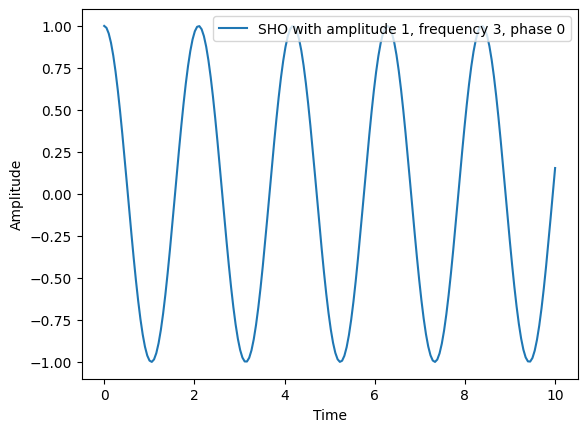

In [15]:
# Example parameters
example_amplitude = 1
example_phase = 0
example_frequency = 3

example_times = np.linspace(0,10,200) # Example input
def sho(amplitude, frequency, phase, time):
    return amplitude * np.cos(frequency * time + phase)
shos = sho(example_amplitude, example_frequency, example_phase, example_times)
plt.plot(example_times, shos)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend([f"SHO with amplitude {example_amplitude}, frequency {example_frequency}, phase {example_phase}"], loc="upper right")
plt.show()


In [16]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    images = [Image.open(fn) for fn in files]
    images[0].save(outfile, save_all=True, append_images=images[1:], optimize=False, duration=1000/fps, loop=loop)

## Solving with a NN

Lets try to fit a standard Neural network to some training data we get from our solution.

### Step 1: Create some training data from the known analytic solution

In [17]:
# Select some physics parameters
amplitude = 1
frequency = 30
phase = 0

# Create synethtic data
time = torch.linspace(0, 1, 200).view(-1,1)
sho_analytic_solution = sho(amplitude, frequency, phase, time).view(-1,1)

# Create a subsample of the data for training
time_samples = time[0:50:5]
sho_samples = sho_analytic_solution[0:50:5]


### Step 2: Create a standard Feed Forward Fully Connected Nueral network

In [18]:
class shoNN(torch.nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.input_layer = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())
        self.hidden_layers = nn.Sequential(*[nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation()) for _ in range(N_LAYERS-1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x


Before training the NN, lets visualise what we are about to do. The graph below shows the analytic solution in blue, which is an exact solution to the differential equation for a SHO. We have then sampled a subset of the solutions to the equation at specific times to create a training 'y' variable, and will be fed to the NN for training. 

Note that the training data onll covers a small subset of the full range of 'x' values. This is important as it highlights that we are not going to simply fit the NN to the functional data, rather a subset of the data and 'learn' the rest of the solution by providing it 'physical insight' directly into the loss function.

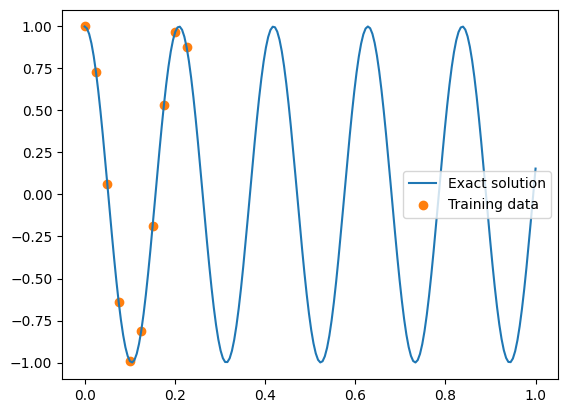

In [19]:
plt.figure()
plt.plot(time, sho_analytic_solution, label="Exact solution")
plt.scatter(time_samples, sho_samples, color="tab:orange", label="Training data")
plt.legend()
plt.show()


### Step 3: Create some plotting functions for easy visualisation

In [20]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

### Step 4: Train the NN on training data with a normal MSE loss

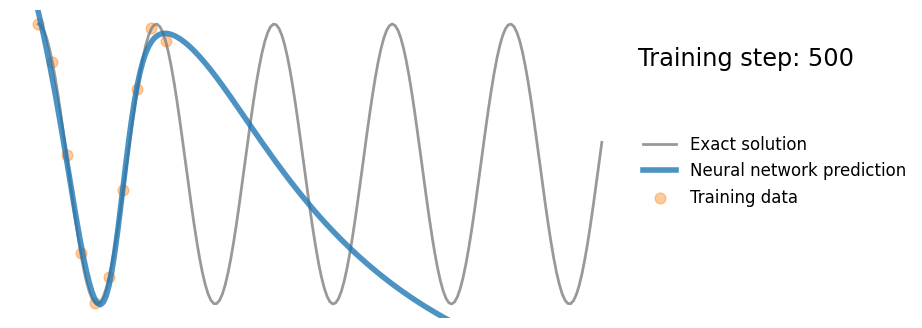

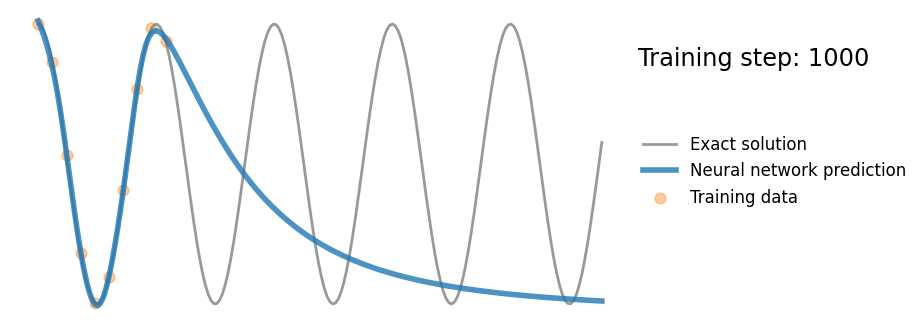

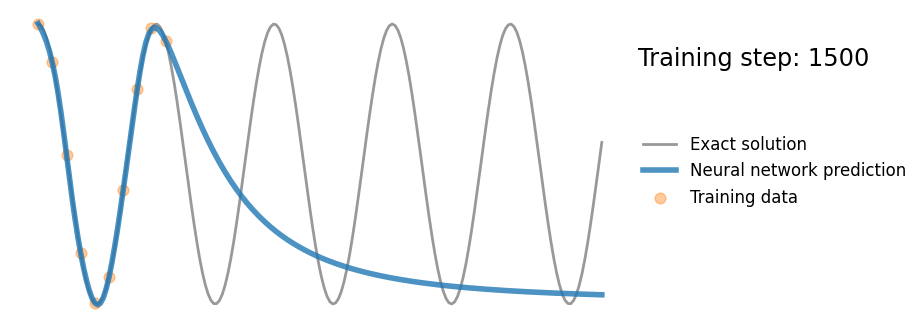

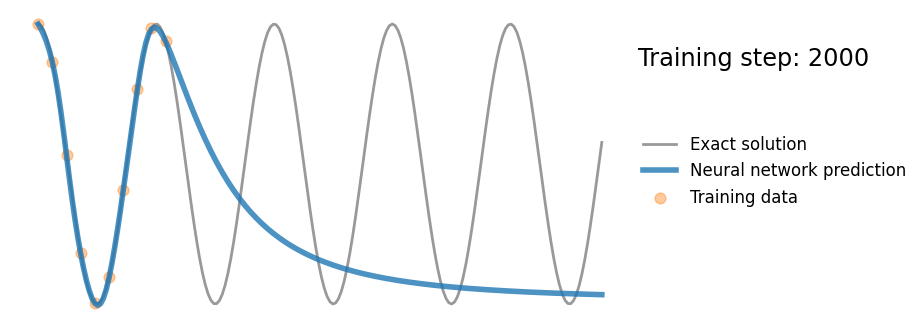

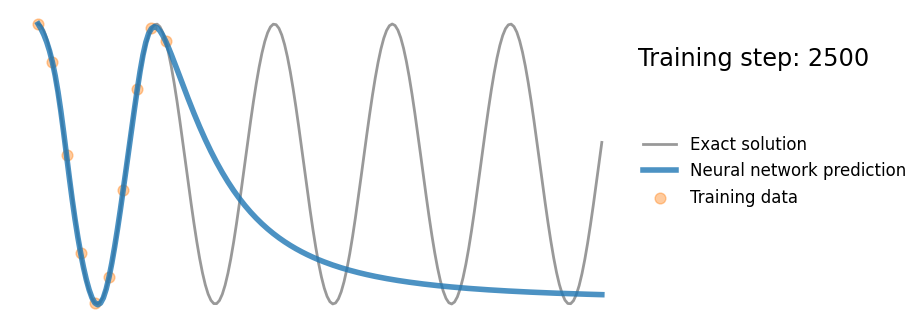

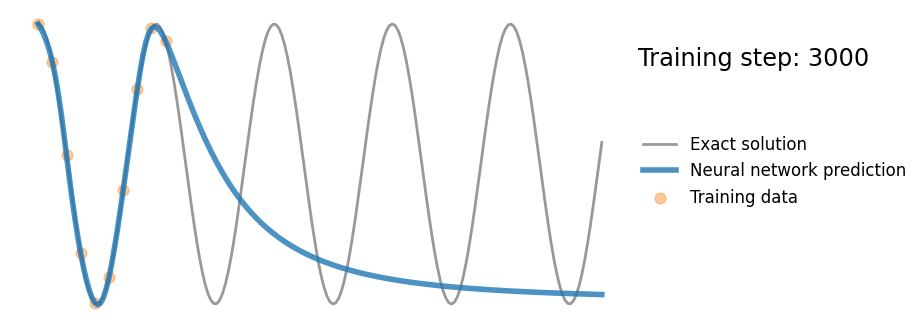

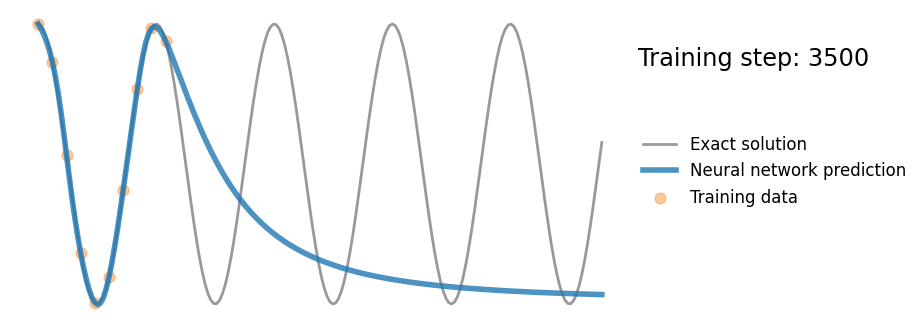

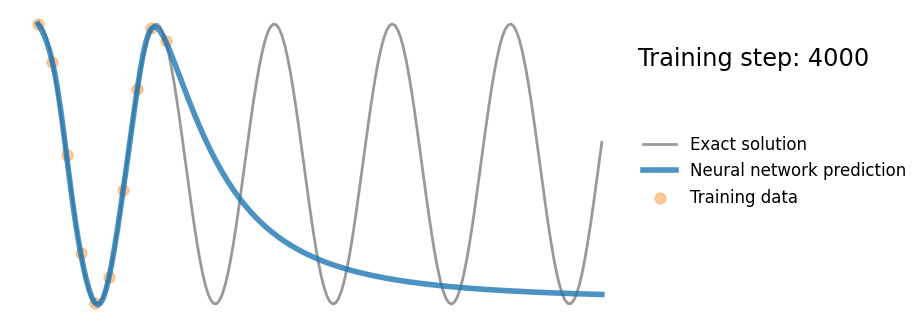

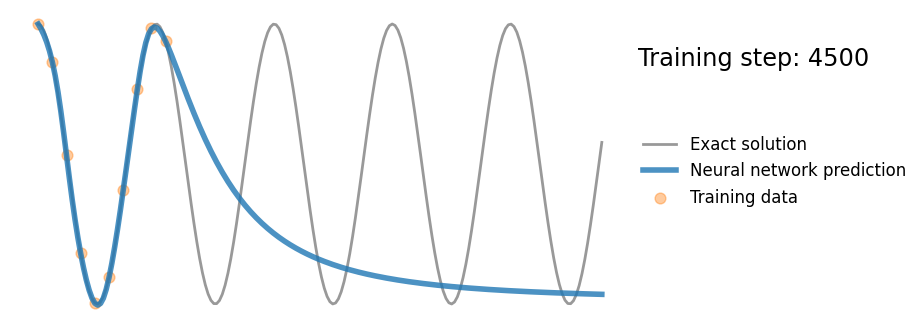

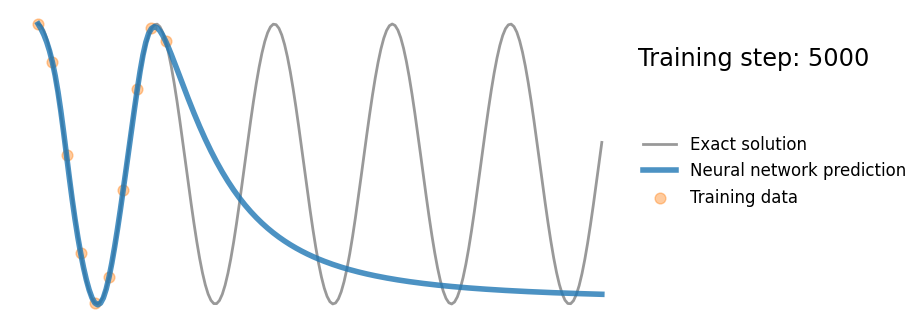

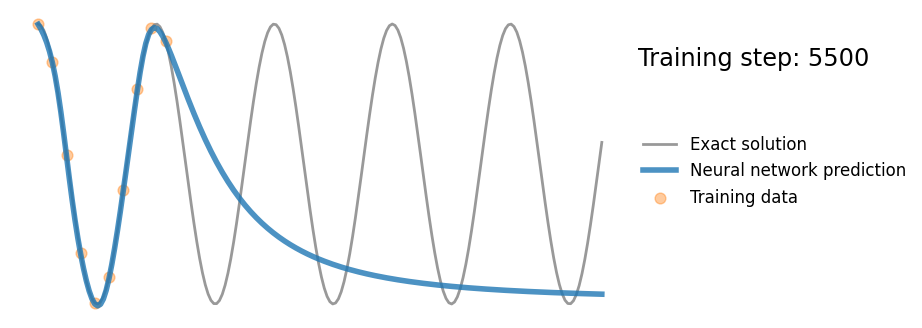

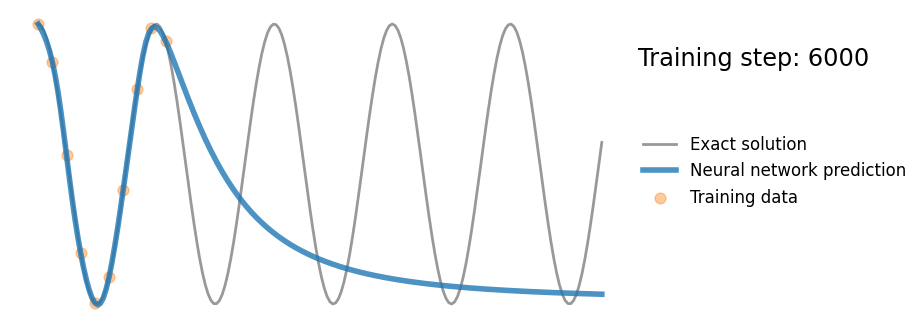

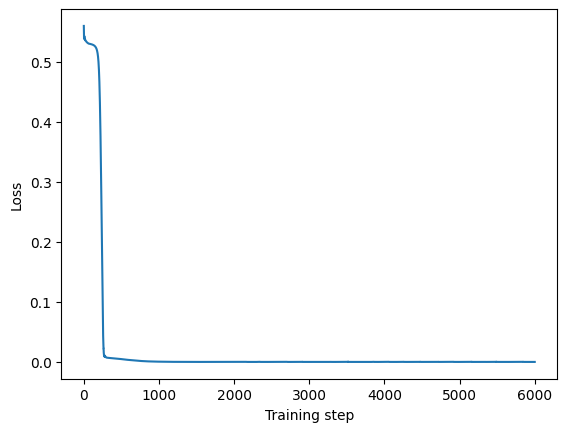

In [21]:
# train standard neural network to fit training data
torch.manual_seed(123)
model = shoNN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
losses = []
for i in range(6000):
    optimizer.zero_grad()
    sho_predicted = model(time_samples)
    loss = torch.mean((sho_predicted-sho_samples)**2)# use mean squared error
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        sho_predicted_plot = model(time).detach()
        
        plot_result(time,sho_analytic_solution,time_samples,sho_samples,sho_predicted_plot)
        
        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")

plt.plot(losses)
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.show()
save_gif_PIL("nn.gif", files, fps=20, loop=0)

Lets reflect on these results.
1. We see that the NN fits the training data we provided perfectly, which is no surprise as it has more than enough parameters (in fact, in this case more parameters than data points). So the system is completely overfit
2. We see that it tries to learn but the loss function platues fairly rapidly with no change with training steps. The final result is a model that simply cannot predict the unseen data

### Step 5: Train the NN with SHO and boundary term loss

The SHO loss function is:

$$
L_{sho} = \frac{1}{N} \sum \left(\frac{d^2x}{dt^2} +\omega^2 x \right)^2
$$

And the boundary loss is:

$$
L_{boundary} = (x(t_{initial}) - 1)^2 + \left( \frac{dx}{dt}(t_{initial}) \right)^2
$$

where $t_{initial} = 0$. This simply says that the initial amplitude is 1 (and hence a cosine) and the initial velocity is 0.

Now lets train a NN with these loss terms and various example parameters

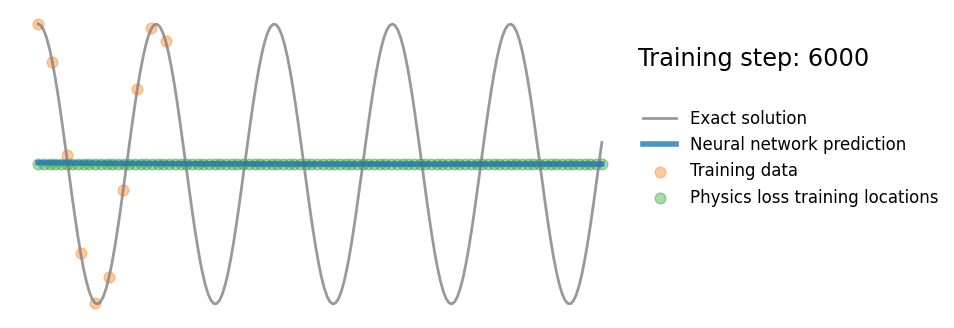

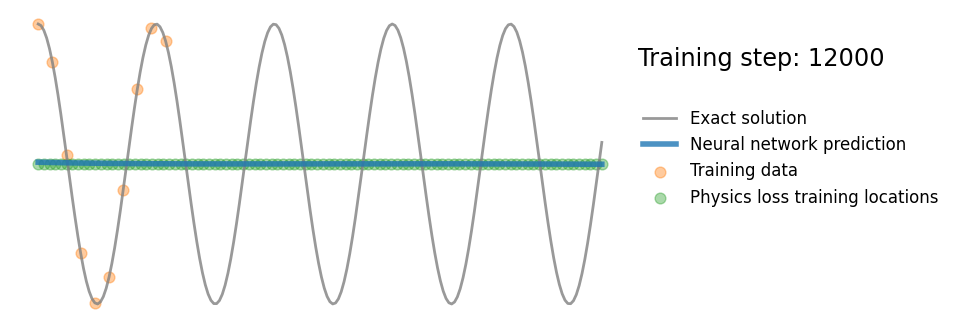

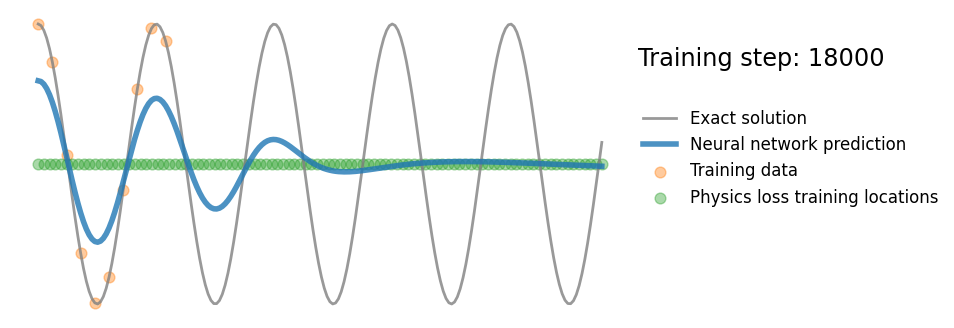

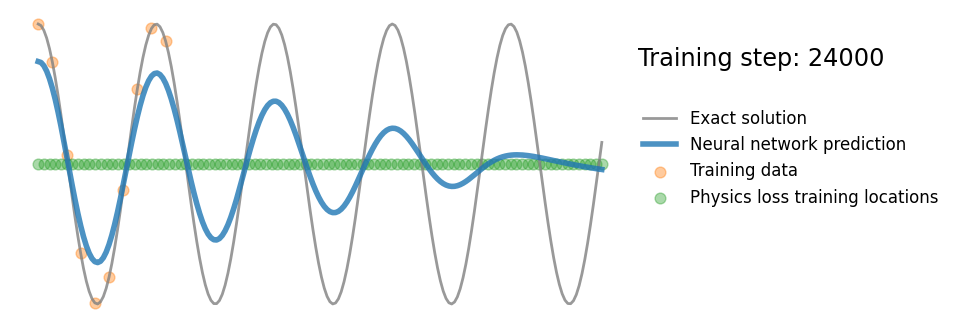

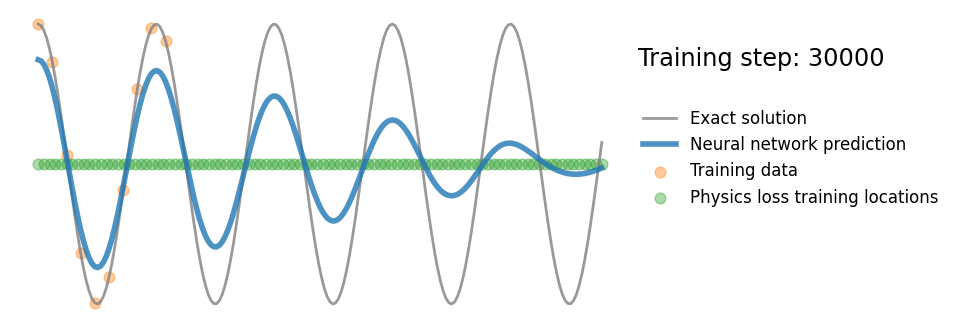

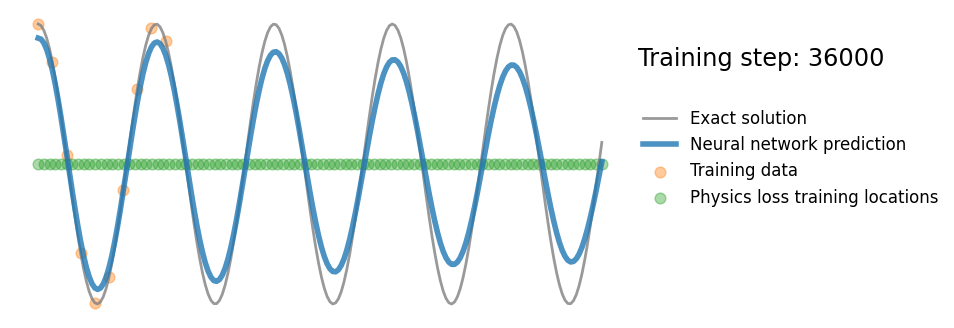

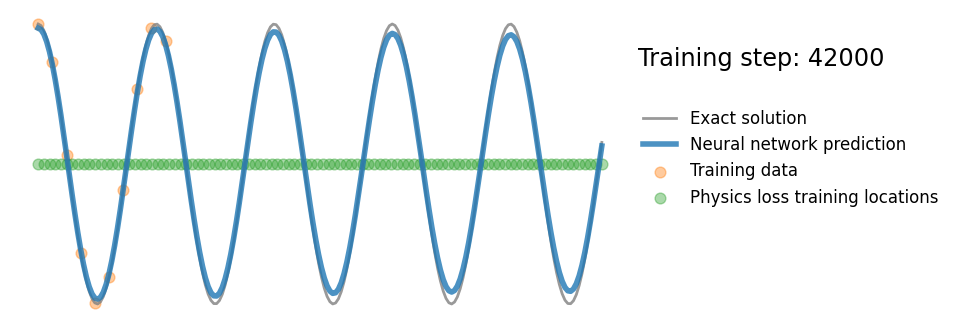

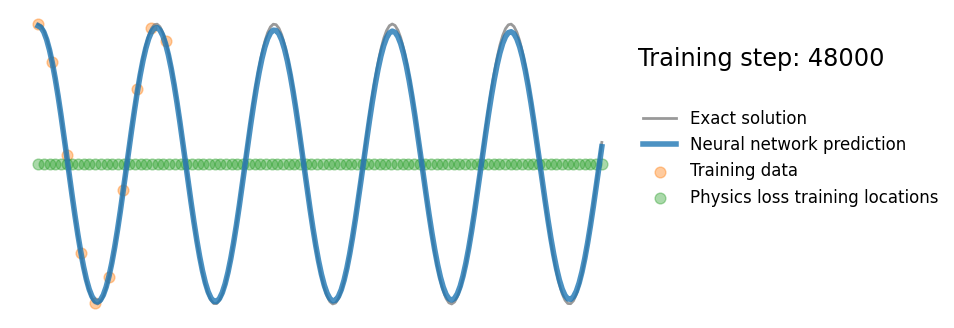

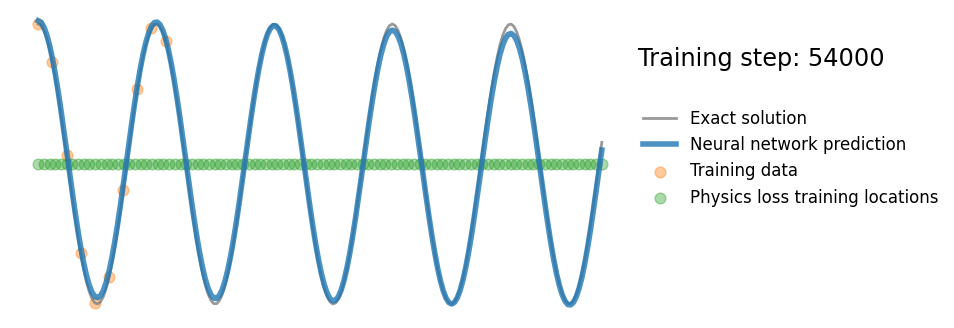

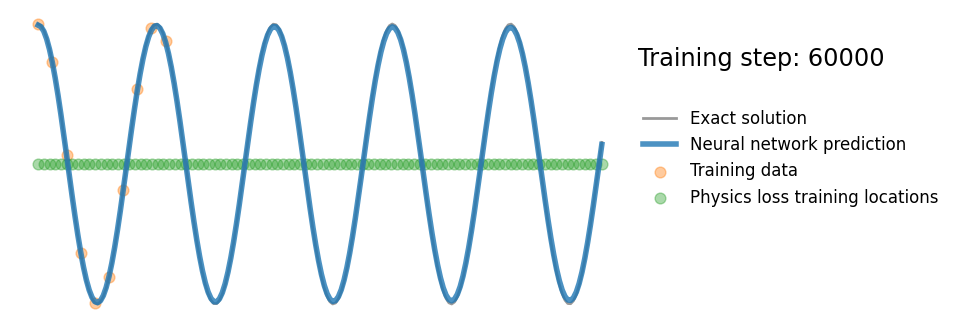

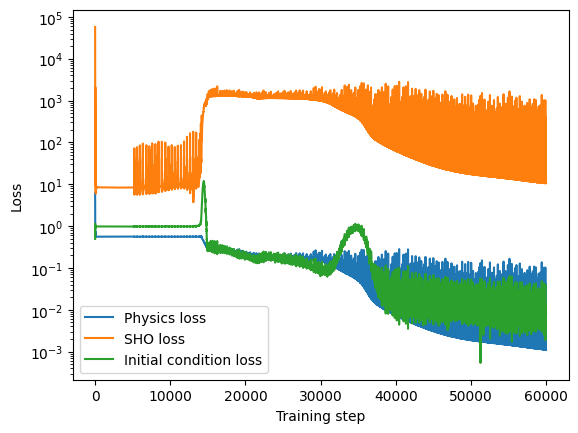

In [22]:
time_physics = torch.linspace(0, 1, 100).view(-1,1).requires_grad_(True) # Generate some time values that we will run the SHO neaural network on

initial_time = torch.tensor(0.).view(-1,1).requires_grad_(True) # providing initial time = 0 for initial conditions, x(t)=1, dx/dt=0
torch.manual_seed(1)
model = shoNN(1,1,32,3)
files = []
sho_loss_weight =  1e-4
initial_condition_loss_weight = 1e-4
#frequency = nn.Parameter(torch.zeros(1, requires_grad=True))
frequency = 30

#optimizer = torch.optim.Adam(list(model.parameters())+[frequency],lr=1e-2)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

losses_physics = []
losses_sho = []
losses_initial_condition = []

for i in range(60000):
    optimizer.zero_grad()
    sho_predicted = model(time_samples)
    loss1 = torch.mean((sho_predicted-sho_samples)**2)# use mean squared error

    sho_predicted_physics = model(time_physics)
    dtsho_preicted_physics = torch.autograd.grad(sho_predicted_physics, time_physics, torch.ones_like(sho_predicted_physics), create_graph=True)[0]
    d2tsho_preicted_physics = torch.autograd.grad(dtsho_preicted_physics, time_physics, torch.ones_like(dtsho_preicted_physics), create_graph=True)[0]
    sho_loss = torch.mean((d2tsho_preicted_physics + frequency**2*sho_predicted_physics)**2)

    initial_sho_x = model(initial_time)
    initial_sho_dt = torch.autograd.grad(initial_sho_x, initial_time, torch.ones_like(initial_sho_x), create_graph=True)[0]
    initial_condition_loss = (torch.squeeze(initial_sho_x) - 1)**2 + (torch.squeeze(initial_sho_dt))**2

    loss = loss1 + sho_loss_weight*sho_loss + initial_condition_loss_weight*initial_condition_loss
    loss.backward()
    optimizer.step()
    losses_sho.append(sho_loss.item())
    losses_initial_condition.append(initial_condition_loss.item())
    losses_physics.append(loss.item())

    if (i+1) % 150 == 0:
        sho_predicted = model(time).detach()
        time_p = time_physics.detach()

        plot_result(time,sho_analytic_solution,time_samples,sho_samples,sho_predicted,time_p)
        file = "plots/nn_physics_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 6000 == 0:
            plt.show()
        else:
            plt.close('all')

plt.plot(losses_physics, label="Physics loss")
plt.plot(losses_sho, label="SHO loss")
plt.plot(losses_initial_condition, label="Initial condition loss")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

save_gif_PIL('physics_nn.gif', files, fps=20, loop=0)

